In [1]:
import numpy as np
from sklearn.model_selection import train_test_split


import visual_bars.generate_visual_bars_data as vbd
from cfl.experiment import Experiment

import optuna
from optuna.integration import KerasPruningCallback
from optuna.trial import TrialState

from keras import Sequential
from keras.layers import Dense, Dropout
# TODO: install keras in requirements or instructions here

Using TensorFlow backend.


In [2]:
# create visual bars data 
n_samples = 10000 
im_shape = (10, 10) 
noise_lvl= 0.03
random_state = 180

vb_data = vbd.VisualBarsData(n_samples=n_samples, im_shape=im_shape, 
                             noise_lvl=noise_lvl, set_random_seed=random_state)

# retrieve the images and the target 
X = vb_data.getImages()
X = np.reshape(X, (X.shape[0], np.product(X.shape[1:]))) # flatten images
Y = vb_data.getTarget()
Y = np.expand_dims(Y, -1)
print(X.shape)
print(Y.shape)

# define train and validation sets to remain constant across tuning
in_sample_idx, out_sample_idx = train_test_split(range(X.shape[0]),
                                                 train_size=0.75,
                                                 random_state=42)


(10000, 100)
(10000, 1)


In [3]:
def build_model(trial):
    
    # vary number of layers
    n_layers = trial.suggest_int("n_layers", 1, 5)
    model = Sequential()
    
    for i in range(n_layers):
        # vary size of each layer
        num_hidden = trial.suggest_int("n_units_l{}".format(i), 4, 512, log=True)
        model.add(Dense(num_hidden, activation="relu"))

        # vary amount of dropout for each layer
        dropout = trial.suggest_float("dropout_l{}".format(i), 0.0, 0.5)
        model.add(Dropout(rate=dropout))

    # add output layer with size of target    
    model.add(Dense(Y.shape[1], activation="linear"))

    return model

In [4]:
def objective(trial):
    data_info = {'X_dims': X.shape, 'Y_dims': Y.shape, 'Y_type': 'categorical'}

    CDE_params = {
        'model'           : 'CondExpDIY',
        'optuna_callback' : KerasPruningCallback(trial, "val_loss"),
        'optuna_trial'    : trial,
        'build_model'     : build_model,

        'lr'              : trial.suggest_float("lr", 1e-5, 1e-1, log=True),                
        'batch_size'      : trial.suggest_int("batch_size", 16, 128),
        'n_epochs'        : 100,
        'optimizer'       : 'adam',
        'loss'            : 'mean_squared_error',
        'best'            : True, 
        'verbose'         : 0,
        'early_stopping'  : True,
    }

    block_names = ['CDE']
    block_params = [CDE_params]

    my_exp = Experiment(X_train=X, 
                        Y_train=Y, 
                        in_sample_idx=in_sample_idx,
                        out_sample_idx=out_sample_idx,
                        data_info=data_info, 
                        block_names=block_names, 
                        block_params=block_params, 
                        verbose=0,
                        results_path=None) # we don't want to save 100's of results

    train_results = my_exp.train()     
    score = train_results['CDE']['val_loss'][-1]
    return score

[I 2021-10-22 16:46:45,405] A new study created in memory with name: no-name-fe4b8dff-1a89-4a44-87ab-ca6e36361749
ipykernel_launcher:6: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0


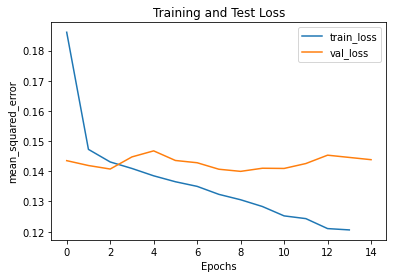

[I 2021-10-22 16:47:14,711] Trial 0 finished with value: 0.14384396480321884 and parameters: {'lr': 0.08068992636292066, 'batch_size': 102, 'n_layers': 3, 'n_units_l0': 213, 'dropout_l0': 0.25859239774876464, 'n_units_l1': 13, 'dropout_l1': 0.029408489779054026, 'n_units_l2': 497, 'dropout_l2': 0.07955107747269996}. Best is trial 0 with value: 0.14384396480321884.
ipykernel_launcher:6: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0


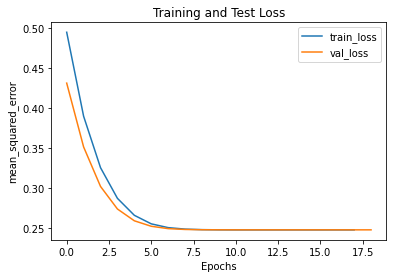

[I 2021-10-22 16:47:52,900] Trial 1 finished with value: 0.24773431082963943 and parameters: {'lr': 0.01167212831902496, 'batch_size': 58, 'n_layers': 3, 'n_units_l0': 233, 'dropout_l0': 0.4412587104367275, 'n_units_l1': 363, 'dropout_l1': 0.41747163078684135, 'n_units_l2': 5, 'dropout_l2': 0.054186228437571315}. Best is trial 0 with value: 0.14384396480321884.
ipykernel_launcher:6: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0


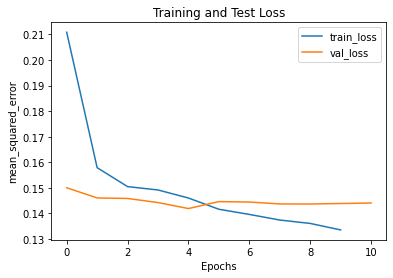

[I 2021-10-22 16:48:02,364] Trial 2 finished with value: 0.14404052444696427 and parameters: {'lr': 0.0014268589672361501, 'batch_size': 94, 'n_layers': 2, 'n_units_l0': 204, 'dropout_l0': 0.1410965799286487, 'n_units_l1': 19, 'dropout_l1': 0.16878921576663253}. Best is trial 0 with value: 0.14384396480321884.
ipykernel_launcher:6: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0


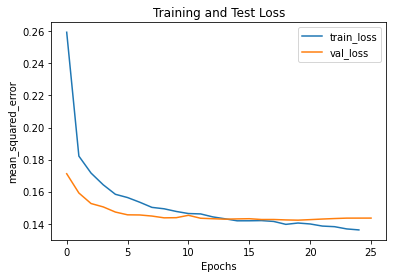

[I 2021-10-22 16:48:10,994] Trial 3 finished with value: 0.14350331945419312 and parameters: {'lr': 0.00022156455792068163, 'batch_size': 112, 'n_layers': 1, 'n_units_l0': 11, 'dropout_l0': 0.09845751058775393}. Best is trial 3 with value: 0.14350331945419312.
ipykernel_launcher:6: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0


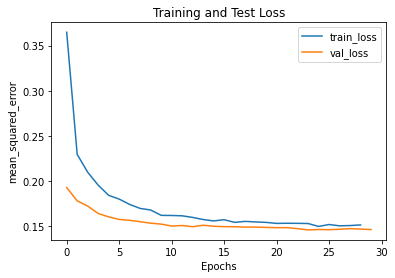

[I 2021-10-22 16:48:31,398] Trial 4 finished with value: 0.1459863924741745 and parameters: {'lr': 0.024824787530787734, 'batch_size': 43, 'n_layers': 1, 'n_units_l0': 10, 'dropout_l0': 0.37531932529489515}. Best is trial 3 with value: 0.14350331945419312.
ipykernel_launcher:6: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0
[I 2021-10-22 16:48:47,610] Trial 5 pruned. Trial was pruned at epoch 0.
[I 2021-10-22 16:48:57,485] Trial 6 pruned. Trial was pruned at epoch 2.
[I 2021-10-22 16:49:05,668] Trial 7 pruned. Trial was pruned at epoch 0.


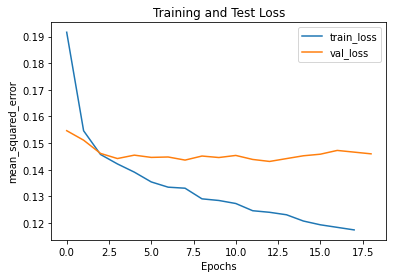

[I 2021-10-22 16:49:15,066] Trial 8 finished with value: 0.14597616838812827 and parameters: {'lr': 0.00024021877397267298, 'batch_size': 98, 'n_layers': 1, 'n_units_l0': 72, 'dropout_l0': 0.06343686259026682}. Best is trial 3 with value: 0.14350331945419312.
ipykernel_launcher:6: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0
[I 2021-10-22 16:49:27,686] Trial 9 pruned. Trial was pruned at epoch 11.
[I 2021-10-22 16:49:33,217] Trial 10 pruned. Trial was pruned at epoch 0.
[I 2021-10-22 16:49:41,125] Trial 11 pruned. Trial was pruned at epoch 0.
[I 2021-10-22 16:4

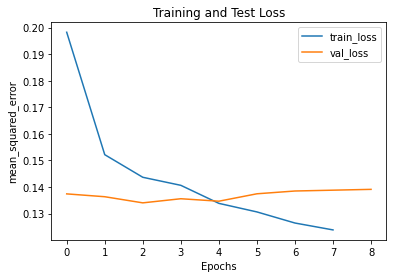

[I 2021-10-22 16:50:25,361] Trial 16 finished with value: 0.13911808432340622 and parameters: {'lr': 8.102412238027936e-05, 'batch_size': 86, 'n_layers': 5, 'n_units_l0': 492, 'dropout_l0': 0.028528236672351437, 'n_units_l1': 37, 'dropout_l1': 0.05844771462500773, 'n_units_l2': 27, 'dropout_l2': 0.01749639403632755, 'n_units_l3': 4, 'dropout_l3': 0.046062271106556724, 'n_units_l4': 505, 'dropout_l4': 0.4944232649447192}. Best is trial 16 with value: 0.13911808432340622.
ipykernel_launcher:6: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0
[I 2021-10-22 16:50:33,53

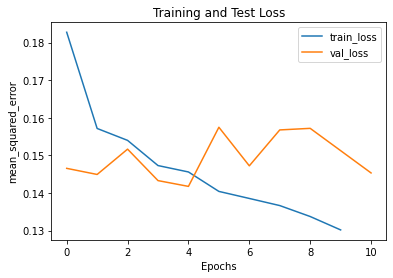

[I 2021-10-22 16:51:11,271] Trial 19 finished with value: 0.14531598600149154 and parameters: {'lr': 0.00020705827502896966, 'batch_size': 63, 'n_layers': 4, 'n_units_l0': 436, 'dropout_l0': 0.11505402535183226, 'n_units_l1': 177, 'dropout_l1': 0.42662116139311534, 'n_units_l2': 30, 'dropout_l2': 0.010365971942366894, 'n_units_l3': 103, 'dropout_l3': 0.2801785690669469}. Best is trial 16 with value: 0.13911808432340622.
ipykernel_launcher:6: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0
[I 2021-10-22 16:51:20,322] Trial 20 pruned. Trial was pruned at epoch 0.


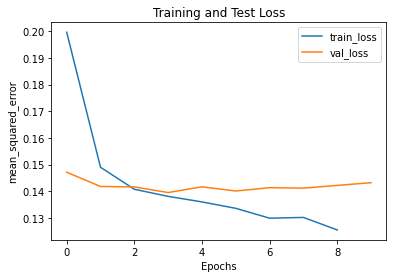

[I 2021-10-22 16:51:36,929] Trial 21 finished with value: 0.1431885087043047 and parameters: {'lr': 0.0004555789957944881, 'batch_size': 107, 'n_layers': 3, 'n_units_l0': 453, 'dropout_l0': 0.17712762227217582, 'n_units_l1': 16, 'dropout_l1': 0.03654445634322566, 'n_units_l2': 54, 'dropout_l2': 0.017850348407399214}. Best is trial 16 with value: 0.13911808432340622.
ipykernel_launcher:6: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0
[I 2021-10-22 16:51:53,058] Trial 22 pruned. Trial was pruned at epoch 7.
[I 2021-10-22 16:52:00,508] Trial 23 pruned. Trial was pr

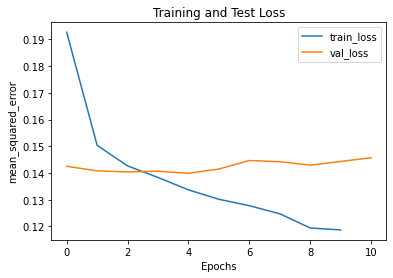

[I 2021-10-22 16:52:12,641] Trial 24 finished with value: 0.14571620378792285 and parameters: {'lr': 0.00018931059099030193, 'batch_size': 89, 'n_layers': 1, 'n_units_l0': 338, 'dropout_l0': 0.210150178867765}. Best is trial 16 with value: 0.13911808432340622.
ipykernel_launcher:6: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0


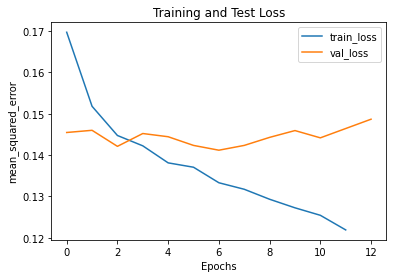

[I 2021-10-22 16:52:30,063] Trial 25 finished with value: 0.14867373940348624 and parameters: {'lr': 8.88113355867912e-05, 'batch_size': 69, 'n_layers': 3, 'n_units_l0': 116, 'dropout_l0': 0.1218807061863566, 'n_units_l1': 39, 'dropout_l1': 0.001005779334613599, 'n_units_l2': 55, 'dropout_l2': 0.14034246394573743}. Best is trial 16 with value: 0.13911808432340622.
ipykernel_launcher:6: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0
[I 2021-10-22 16:52:38,062] Trial 26 pruned. Trial was pruned at epoch 0.
[I 2021-10-22 16:52:42,704] Trial 27 pruned. Trial was prun

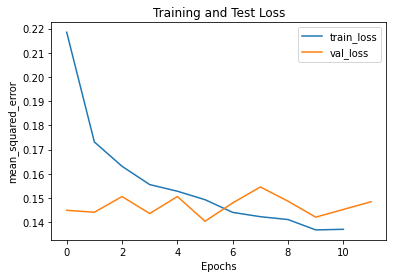

[I 2021-10-22 16:53:04,737] Trial 29 finished with value: 0.1484587417960167 and parameters: {'lr': 0.00027046131649338743, 'batch_size': 102, 'n_layers': 3, 'n_units_l0': 492, 'dropout_l0': 0.21925990111147306, 'n_units_l1': 29, 'dropout_l1': 0.24530179199388305, 'n_units_l2': 31, 'dropout_l2': 0.18520609861419918}. Best is trial 16 with value: 0.13911808432340622.
ipykernel_launcher:6: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0
[I 2021-10-22 16:53:14,859] Trial 30 pruned. Trial was pruned at epoch 0.


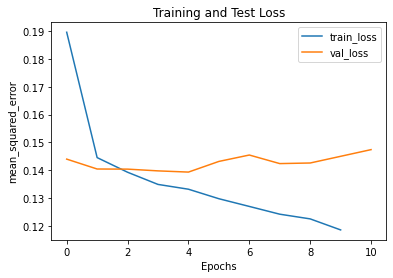

[I 2021-10-22 16:53:31,975] Trial 31 finished with value: 0.1473883265018463 and parameters: {'lr': 0.009007832577618896, 'batch_size': 104, 'n_layers': 3, 'n_units_l0': 243, 'dropout_l0': 0.08453010144738982, 'n_units_l1': 13, 'dropout_l1': 0.0266688695318447, 'n_units_l2': 266, 'dropout_l2': 0.07710807748311246}. Best is trial 16 with value: 0.13911808432340622.
ipykernel_launcher:6: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0


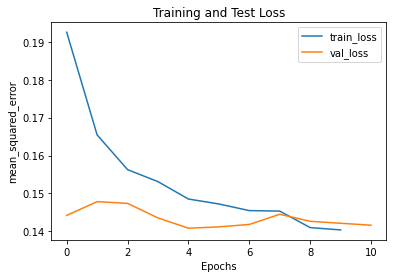

[I 2021-10-22 16:53:48,475] Trial 32 finished with value: 0.14158855970799922 and parameters: {'lr': 0.00012407197334517213, 'batch_size': 93, 'n_layers': 3, 'n_units_l0': 251, 'dropout_l0': 0.2844050232963351, 'n_units_l1': 17, 'dropout_l1': 0.04032166531268478, 'n_units_l2': 8, 'dropout_l2': 0.09276684106850368}. Best is trial 16 with value: 0.13911808432340622.
ipykernel_launcher:6: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0


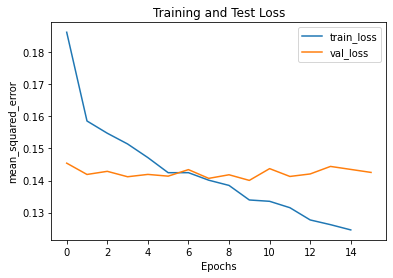

[I 2021-10-22 16:54:11,092] Trial 33 finished with value: 0.1425356972873211 and parameters: {'lr': 0.00011537750228154256, 'batch_size': 97, 'n_layers': 3, 'n_units_l0': 258, 'dropout_l0': 0.27125535208540186, 'n_units_l1': 19, 'dropout_l1': 0.11285637840766187, 'n_units_l2': 9, 'dropout_l2': 0.010181880919469494}. Best is trial 16 with value: 0.13911808432340622.
ipykernel_launcher:6: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0
[I 2021-10-22 16:54:22,463] Trial 34 pruned. Trial was pruned at epoch 0.
[I 2021-10-22 16:54:34,958] Trial 35 pruned. Trial was pru

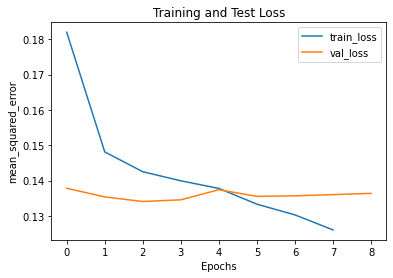

[I 2021-10-22 16:55:24,937] Trial 41 finished with value: 0.13637703345417976 and parameters: {'lr': 0.0006133878525550237, 'batch_size': 107, 'n_layers': 2, 'n_units_l0': 507, 'dropout_l0': 0.1402230593109488, 'n_units_l1': 11, 'dropout_l1': 0.03310013335979289}. Best is trial 41 with value: 0.13637703345417976.
ipykernel_launcher:6: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0
[I 2021-10-22 16:55:32,146] Trial 42 pruned. Trial was pruned at epoch 0.


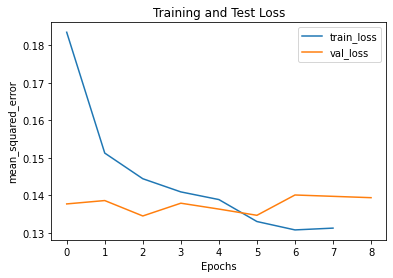

[I 2021-10-22 16:55:49,347] Trial 43 finished with value: 0.13933918403089046 and parameters: {'lr': 0.0005936593069652877, 'batch_size': 117, 'n_layers': 2, 'n_units_l0': 502, 'dropout_l0': 0.22583098817379724, 'n_units_l1': 22, 'dropout_l1': 0.0655898010305212}. Best is trial 41 with value: 0.13637703345417976.
ipykernel_launcher:6: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0
[I 2021-10-22 16:55:55,344] Trial 44 pruned. Trial was pruned at epoch 0.
[I 2021-10-22 16:56:00,447] Trial 45 pruned. Trial was pruned at epoch 0.
[I 2021-10-22 16:56:04,584] Trial 46 

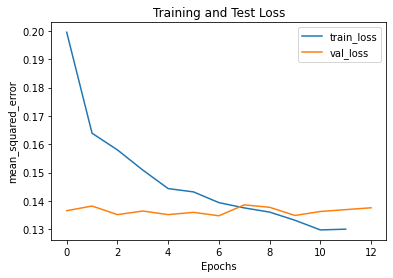

[I 2021-10-22 16:56:18,617] Trial 47 finished with value: 0.1375587103396654 and parameters: {'lr': 0.00012810671773259402, 'batch_size': 79, 'n_layers': 2, 'n_units_l0': 354, 'dropout_l0': 0.2567099535695609, 'n_units_l1': 5, 'dropout_l1': 0.06336551711458199}. Best is trial 41 with value: 0.13637703345417976.
ipykernel_launcher:6: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0
[I 2021-10-22 16:56:23,977] Trial 48 pruned. Trial was pruned at epoch 0.
[I 2021-10-22 16:56:28,437] Trial 49 pruned. Trial was pruned at epoch 0.


In [5]:
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=50)

In [10]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  50
  Number of pruned trials:  32
  Number of complete trials:  18
Best trial:
  Value:  0.13637703345417976
  Params: 
    lr: 0.0006133878525550237
    batch_size: 107
    n_layers: 2
    n_units_l0: 507
    dropout_l0: 0.1402230593109488
    n_units_l1: 11
    dropout_l1: 0.03310013335979289


All results from this run will be saved to demo_results/experiment0005
#################### Beginning CFL Experiment training. ####################
Beginning CDE training...


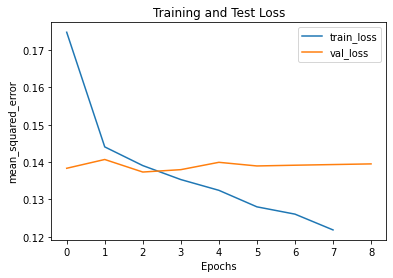

CDE training complete.
Beginning CauseClusterer training...
CauseClusterer training complete.
Experiment training complete.


In [15]:
# so our optimized model becomes:

def build_optimized_model():

    # vary number of layers
    n_layers = study.best_trial.params['n_layers']
    model = Sequential()
    for i in range(n_layers):
        # vary size of each layer
        num_hidden = study.best_trial.params[f'n_units_l{i}']
        model.add(Dense(num_hidden, activation="relu"))

        # vary amount of dropout for each layer
        dropout = study.best_trial.params[f'dropout_l{i}']
        model.add(Dropout(rate=dropout))

    # add output layer with size of target    
    model.add(Dense(Y.shape[1], activation="linear"))
    return model

data_info = {'X_dims': X.shape, 'Y_dims': Y.shape, 'Y_type': 'categorical'}

CDE_params = {
    'model'           : 'CondExpDIY',
    'build_model'     : build_optimized_model,

    'lr'              : study.best_trial.params['lr'],                
    'batch_size'      : study.best_trial.params['batch_size'],
    'n_epochs'        : 100,
    'optimizer'       : 'adam',
    'loss'            : 'mean_squared_error',
    'best'            : True, 
    'verbose'         : 0,
    'early_stopping'  : True
}

cause_cluster_params = {'model' : 'KMeans', 'n_clusters' : 4, 'verbose' : 0}

block_names = ['CDE', 'CauseClusterer']
block_params = [CDE_params, cause_cluster_params]

my_exp = Experiment(X_train=X, Y_train=Y, data_info=data_info, 
                    in_sample_idx=in_sample_idx, out_sample_idx=out_sample_idx,
                    block_names=block_names, block_params=block_params, 
                    results_path='demo_results')

train_results = my_exp.train()     

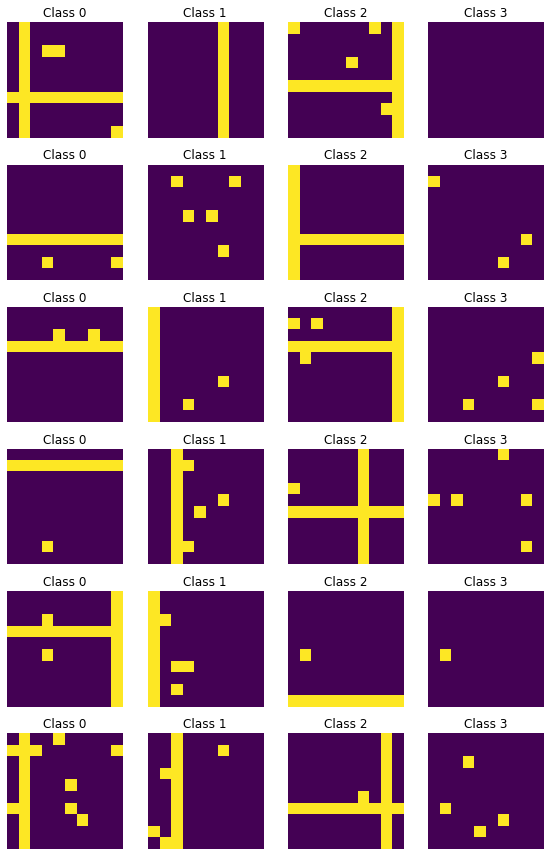

In [16]:
import cfl.visualization_methods.visual_bars_vis as vis

vis.viewImagesAndLabels(X, im_shape=im_shape, n_examples=6, 
                        x_lbls=train_results['CauseClusterer']['x_lbls'])

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='Sample', ylabel='Expectation of Target'>)

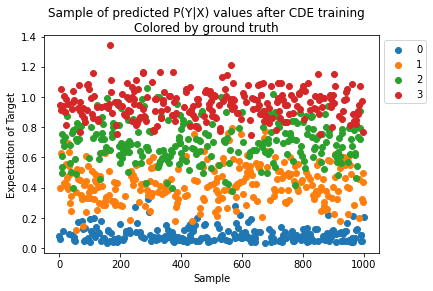

In [17]:
from cfl.visualization_methods.cde_diagnostic import pyx_scatter
pyx_scatter(my_exp, vb_data.getGroundTruth())